# Basic MRS data analysis with SMAL

In [1]:
import os.path as op
import MRS.data as mrd
import MRS.utils as mru
import urllib as url
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import nitime.timeseries as nts
import nitime.viz as viz
%matplotlib inline

/Users/arokem/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/__init__.py:1256: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/Users/arokem/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/cbook.py:133: MatplotlibDeprecationWarning: The matplotlib.mpl module was deprecated in version 1.3. Use `import matplotlib as mpl` instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


We start by downloading some MRS data from the Stanford Data Repository:

In [2]:
mrd.fetch_from_sdr(data='example')

File /Users/arokem/.mrs_data/5062_2_1.nii.gz is already in place. If you want to fetch it again, please first remove it from the folder /Users/arokem/.mrs_data 
File /Users/arokem/.mrs_data/12_1_PROBE_MEGA_L_Occ.nii.gz is already in place. If you want to fetch it again, please first remove it from the folder /Users/arokem/.mrs_data 
Done.
Files copied in folder /Users/arokem/.mrs_data


In [3]:
fname = '12_1_PROBE_MEGA_L_Occ.nii.gz'
fpath = op.join(mrd.data_folder, fname)    

Let's examine the structure of the file. This is a standard nifti file, so it can be read using `nibabel`. 

In [4]:
import nibabel as nib

In [5]:
mrs_nifti = nib.load(fpath)

In [6]:
print(mrs_nifti.shape)

(4096, 1, 1, 68, 2, 32)


These are according to their their order: 

- The temporal samples. Here 4096 samples, at 5000 Hz 
- First spatial dimension. This will usually be 1, because we sample only one spatial location. 
- Second spatial dimension. Also 1
- The number of transients ('trials') in the experiment. Here we have 4 water-sensitive transients and 64 transients with water suppression
- The number of echos in each set of transients. Here we have 2 : one has gaba editing on and one has gaba editing off. The difference between these will contain a GABA-indicative peak at 3 ppm. 
- The number of coils measured. Here 32 coils - the standard phased-array coil used at the CNI.


If your data is not in a nifti file, or not organized according to these conventions, you will need to do some preprocessing to get it into this form! 

The data has a 'complex' `dtype`:

In [7]:
mrs_data = mrs_nifti.get_data()
mrs_data.dtype

dtype('<c16')

That is, each number is a complex number, because the measurement is done in quadrature (see also [this other notebook](002-principles-of-MRS.ipynb) for more details). 

Using `nitime`, we can plot the phase and the amplitude of the measurement. We select the 5th transient, which is the first water-suppressed transient in the experiment

In [8]:
ts_abs = nts.TimeSeries(np.abs(mrs_data[:,0,0,4,0,0]), sampling_rate=5000., time_unit='ms')
ts_angle = nts.TimeSeries(np.angle(mrs_data[:,0,0,4,0,0]), sampling_rate=5000., time_unit='ms')

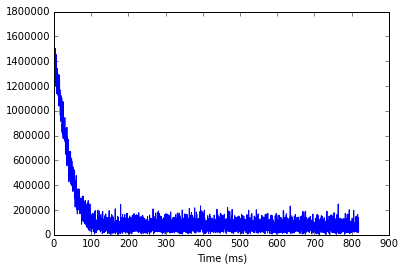

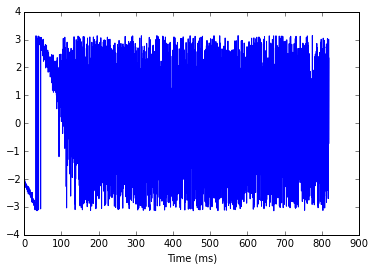

In [9]:
fig = viz.plot_tseries(ts_abs)
fig = viz.plot_tseries(ts_angle)

The magnitude of the signal decays quickly. The is the FID curve. The phase precesses more-or-less systematically, as long as the FID is above the noise, but then the phase becomes incoherent.  

Next, let's use the SMAL API to process the data and analyze it

In [10]:
import MRS.api as mrs

This API can accept as input either a full path to a nifti file, or an array that has the data organized as above.  

In [11]:
G = mrs.GABA(fpath)

/Users/arokem/anaconda3/envs/py2/lib/python2.7/site-packages/MRS/leastsqbound/leastsqbound.py:299: RuntimeWarning: Number of calls to function has reached maxfev = 1400.
  warnings.warn(errors[info][0], RuntimeWarning)


Upon initialization, the `GABA` object performed several stages of analysis and processing, that are required before fitting a model of GABA and quantification can be done: 

- Data is combined across coils, using the signal/noise$^2$ rule [Hall2013]. The data from each coil is also zero-order phase corrected, so that they all have similar phases. 

- On-resonance frequency shifts are corrected, by fitting a Lorentzian line-shape to the water peak in the non-water-suppressed transients (per-default, the first transient is discarded, to mitigate onset effects).

- The spectrum of each transient/echo is derived.

- The sum and differences between the echos for each transient are calculated.

Because the original time-series data were complex, the derived spectra are also complex. Following the previous practice in the field, we use the real part of the spectrum for our analysis. Here are the sum spectra and diff spectra (64 repetitions of each)

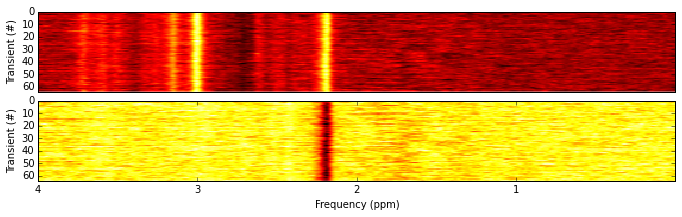

In [12]:
fig, (ax1, ax2) = plt.subplots(2)

for ax in [ax1, ax2]:
    ax.set_ylabel('Transient (#)')
    ax.invert_xaxis()
    
ax1.imshow(np.real(G.sum_spectra[:, G.idx]), interpolation='none', cmap=matplotlib.cm.hot,
           extent=[mru.ppm_to_freq(4.0), mru.ppm_to_freq(0), 64, 0])

ax2.imshow(np.real(G.diff_spectra[:, G.idx]), interpolation='none', cmap=matplotlib.cm.hot,
           extent=[mru.ppm_to_freq(4.0), mru.ppm_to_freq(0), 64, 0])

ax2.set_xticks(mru.ppm_to_freq(np.array([1,2,3,4])))
ax2.set_xticklabels([1,2,3,4])
ax1.set_xticks([])
ax2.set_xlabel('Frequency (ppm)')

fig.set_size_inches([10, 3])
plt.tight_layout()

Note that the object already has the slicing attribute `idx`, which is used to help you focus on the part of the spectrum that you might be interested in. Per default, this includes the range from 0.7 to 4.3 ppm. For 3T, at body temperature, this corresponds to approximately 50 Hz to 700 Hz. It does not contain the large water peak at 0 Hz. Most of the molecular species of interest in the analysis (GABA, Creatine, Glutamate and Glutamine) have resonance peaks between 2 and 4 ppm.  

And here are the traces averaged over all transients for each one of these: 


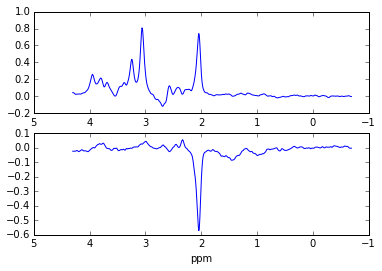

In [13]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(G.f_ppm[G.idx], np.mean(np.real(G.sum_spectra[:, G.idx]), 0))
ax2.plot(G.f_ppm[G.idx], np.mean(np.real(G.diff_spectra[:, G.idx]), 0))
for ax in (ax1, ax2):
    ax.invert_xaxis()

ax2.set_xlabel('ppm')

At this point, we are ready to fit the models to the various peaks in the spectrum. The `GABA` object contains methods for fitting a Lorentzian linewidth to the Creatine and Choline peaks around 3 PPM. Once the Creatine model is fit, we can use the phase shift in the Creatine peak to phase-correct the data in the GABA data as well. 

Once this correction is done, a Gaussian model composed of either one or two Gaussian line-shapes is fit to the GABA data at 3 PPM. A cross-validation procedure is used to select the better model (single or double Gaussian): each model is fit to half of the data (even transients) and model prediction errors are assessed on the other half (odd transients). The same procedure is repeated fitting to the other half (odd transients) and checking on the first half (even transients). The model with smaller prediction error is chosen and fit to all of the transients. 

In [14]:
G.fit_gaba()

/Users/arokem/anaconda3/envs/py2/lib/python2.7/site-packages/MRS/leastsqbound/leastsqbound.py:299: RuntimeWarning: Number of calls to function has reached maxfev = 2200.
  warnings.warn(errors[info][0], RuntimeWarning)
/Users/arokem/anaconda3/envs/py2/lib/python2.7/site-packages/MRS/leastsqbound/leastsqbound.py:299: RuntimeWarning: Number of calls to function has reached maxfev = 1200.
  warnings.warn(errors[info][0], RuntimeWarning)
/Users/arokem/anaconda3/envs/py2/lib/python2.7/site-packages/MRS/leastsqbound/leastsqbound.py:299: RuntimeWarning: Number of calls to function has reached maxfev = 1800.
  warnings.warn(errors[info][0], RuntimeWarning)
/Users/arokem/anaconda3/envs/py2/lib/python2.7/site-packages/MRS/leastsqbound/leastsqbound.py:83: RuntimeWarning: invalid value encountered in sqrt
  return lambda x: sqrt((x - lower + 1.)**2 - 1)


Once the `fit_gaba` method has been called, we can plot the GABA model with the difference spectrum from which it was calculated:

/Users/arokem/anaconda3/envs/py2/lib/python2.7/site-packages/numpy/core/numeric.py:462: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


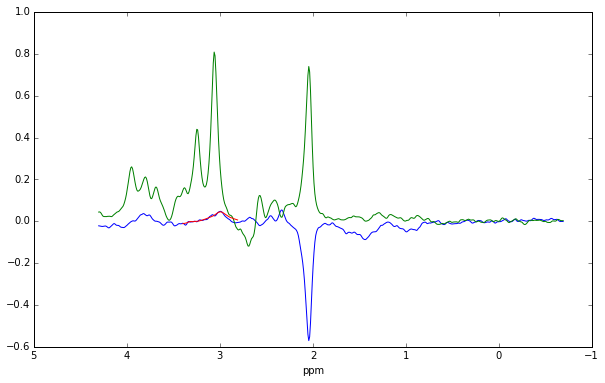

In [15]:
fig, ax = plt.subplots(1)
ax.plot(G.f_ppm[G.idx], stats.nanmean(G.diff_spectra[G._gaba_transients, G.idx], 1).squeeze())
ax.plot(G.f_ppm[G.idx], stats.nanmean(G.sum_spectra[G._gaba_transients, G.idx], 1).squeeze())

ax.plot(G.f_ppm[G.gaba_idx], stats.nanmean(G.gaba_model, 0), 'r')
ax.invert_xaxis()
ax.set_xlabel('ppm')
fig.set_size_inches([10,6])

The areas under the curves for both the creatine and the GABA are calculated from the model parameters for the full function domain, and can be used to calculate their relative abundances: 


In [16]:
print(stats.nanmean(G.gaba_auc)/stats.nanmean(G.creatine_auc))

0.2343405487


Another option is to use the water as a reference: 

In [17]:
G.fit_water()
print(stats.nanmean(G.gaba_auc)/stats.nanmean(G.water_auc))

0.000413400711408


We can demonstrate the cross-validation procedure, by considering the model fit on even/odd trials, compared the measurement. Model fit is relative to the noise in the data, which is demonstrated in the third panel below as the test-retest reliability of the measurement

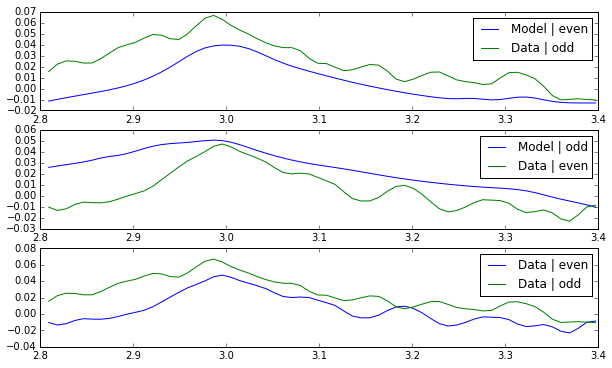

In [19]:
fig, ax = plt.subplots(3)
ax[0].plot(G.f_ppm[G.gaba_idx], np.nanmean(G.gaba_model[::2], 0), label='Model | even')
ax[0].plot(G.f_ppm[G.gaba_idx], np.nanmean(G.gaba_signal[1::2], 0), label='Data | odd')
ax[0].legend()
ax[1].plot(G.f_ppm[G.gaba_idx], np.nanmean(G.gaba_model[1::2], 0), label='Model | odd')
ax[1].plot(G.f_ppm[G.gaba_idx], np.nanmean(G.gaba_signal[::2], 0), label='Data | even')
ax[1].legend()
ax[2].plot(G.f_ppm[G.gaba_idx], np.nanmean(G.gaba_signal[::2], 0), label='Data | even')
ax[2].plot(G.f_ppm[G.gaba_idx], np.nanmean(G.gaba_signal[1::2], 0), label='Data | odd')
ax[2].legend()
fig.set_size_inches([10, 6])

## References

[Hall2013] Emma L. Hall, Mary C. Stephenson, Darren Price, Peter G. Morris (2013). Methodology for improved detection of low concentration metabolites in MRS: Optimised combination of signals from multi-element coil arrays. Neuroimage 86: 35-42.